# **This file is to run code to produce the netCDF dataset for the Summer 2025 SULI appointment**
#### *This file is a cleaned and organized version of the file<br>Coded by Brandon Swanson<br>Mentored by Bhupendra Raut*

#### Imports & Helpers 
##### Enter your time frame in minutes before running

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import xarray as xr
import pandas as pd
from scipy.io import netcdf
import netCDF4 as nc
import os
from datetime import datetime, timedelta
import tempfile
import shutil
import gzip
np.round_ = np.round # this is to go around a metpy bug/version error
from metpy.calc import wind_components
from metpy.units import units
import seaborn as sns

time_frame = 30 # Change this number
time_frame_minutes = time_frame

def merge_only_netcdf(dir1, dir2, output_dir):
    # Gather all netCDF files from both directories
    file_paths1 = glob(os.path.join(dir1, '*.nc'))
    file_paths2 = glob(os.path.join(dir2, '*.nc'))

    # Check if any files were found
    if not file_paths1 and not file_paths2:
        print("No netCDF files found in the specified directories.")
        return

    # Initialize an empty list to store datasets
    datasets = []

    # Open each netCDF file from the first directory and append to the list
    for file_path in file_paths1:
        ds = xr.open_dataset(file_path, engine='netcdf4')
        datasets.append(ds)

    # Collect variable names from the first directory
    first_dir_vars = set(datasets[0].data_vars)

    # Open each netCDF file from the second directory
    for file_path in file_paths2:
        ds = xr.open_dataset(file_path, engine='netcdf4')
        
        # Drop variables that already exist in the first directory
        ds = ds.drop_vars([var for var in ds.data_vars if var in first_dir_vars])
        
        datasets.append(ds)

    # Concatenate all datasets along the time dimension
    combined_data = xr.concat(datasets, dim='time', combine_attrs='override')

    # Sort by time to ensure monotonic index
    combined_data = combined_data.sortby('time')

    # Construct the output file name
    new_file_name = "merged_data.nc"
    output_file_path = os.path.join(output_dir, new_file_name)

    # Save the combined data to a new netCDF file
    combined_data.to_netcdf(output_file_path)
    print(f"Merged data saved to {output_file_path}")

    return combined_data

def average_wind_direction(angles):
    """Calculate the average wind direction from a list of angles."""
    # Convert angles to radians
    angles_rad = np.deg2rad(angles)
    
    # Calculate the mean of the unit vectors
    sin_sum = np.sum(np.sin(angles_rad))
    cos_sum = np.sum(np.cos(angles_rad))
    
    # Calculate the average angle in radians
    mean_angle_rad = np.arctan2(sin_sum, cos_sum)
    
    # Convert the average angle back to degrees
    mean_angle_deg = np.rad2deg(mean_angle_rad)
    
    # Ensure the angle is in the range [0, 360)
    mean_angle_deg = mean_angle_deg % 360
    
    return mean_angle_deg

def merge_netcdf(file_paths, time_frame, output_dir):
    # Convert the time frame to a timedelta object
    time_frame_minutes = int(time_frame.split()[0])
    
    # Initialize an empty list to store datasets
    datasets = []

    # Open each netCDF file and append to the list
    for file_path in file_paths:
        ds = xr.open_dataset(file_path, engine='netcdf4')
        datasets.append(ds)

    # Concatenate all datasets along the time dimension
    combined_data = xr.concat(datasets, dim='time')

    # Resample the data to the specified time frame
    resampled_data = combined_data.resample(time=f'{time_frame_minutes}min').mean()

    # Apply the custom wind direction averaging function
    if 'wind_direction' in resampled_data:
        resampled_data['wind_direction'] = xr.apply_ufunc(
            average_wind_direction,
            resampled_data['wind_direction'],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[float]
        )

    # Construct the output file name
    new_file_name = f"crocus_neiu_a1_merged_{time_frame_minutes}min.nc"
    output_file_path = os.path.join(output_dir, new_file_name)

    # Save the resampled data to a new netCDF file
    resampled_data.to_netcdf(output_file_path)
    print(f"Resampled data saved to {output_file_path}")

    return resampled_data

def new_netcdf(file_paths, output_dir, variables):
    # Initialize an empty list to store datasets
    datasets = []

    # Open each netCDF file and append to the list
    for file_path in file_paths:
        ds = xr.open_dataset(file_path, engine='netcdf4')
        datasets.append(ds)

    # Concatenate all datasets along the time dimension
    combined_data = xr.concat(datasets, dim='time')

    # Filter out unwanted variables
    filtered_data = combined_data[variables]

    # Calculate U and V components of the wind
    wind_dir = filtered_data['wind_dir_10s'].values * units.degrees
    wind_speed = filtered_data['wind_mean_10s'].values * units.meter / units.second
    u, v = wind_components(wind_speed, wind_dir)

    # Add U and V components to the dataset
    filtered_data['u_wind'] = (('time',), u.magnitude)
    filtered_data['v_wind'] = (('time',), v.magnitude)

    # Define the output file name
    new_file_name = f"crocus_neiu_a1_merged_and_filtered_{time_frame_minutes}min.nc"
    output_file_path = os.path.join(output_dir, new_file_name)

    # Save the filtered data to a new netCDF file
    filtered_data.to_netcdf(output_file_path)
    print(f"Filtered data saved to {output_file_path}")

    return filtered_data

def plot_variable_pairs(dataset, time_frame):
    # Convert the xarray dataset to a pandas DataFrame
    df = dataset.to_dataframe().reset_index()

    # Use seaborn to plot pairwise relationships
    sns.pairplot(df)
    plt.show()

#### Merge aqt & wxt data

In [2]:
"""
Run this first after the imports and helpers
"""
# Input the directories containing netCDF files
dir1 = input("Input the first directory path containing netCDF files: ").strip()
dir2 = input("Input the second directory path containing netCDF files: ").strip()
# Input the output directory for the new netCDF file
output_dir = input("Input the output directory for the new netCDF file: ").strip()

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Merge netCDF files and save the result
merge_only_netcdf(dir1, dir2, output_dir)

Input the first directory path containing netCDF files:  D://Test_data//aqt
Input the second directory path containing netCDF files:  D://Test_data//wxt
Input the output directory for the new netCDF file:  D://Test_data//


Merged data saved to D://Test_data//merged_data.nc


<xarray.Dataset> Size: 85MB
Dimensions:        (time: 628370)
Coordinates:
  * time           (time) datetime64[ns] 5MB 2024-06-27T20:30:00 ... 2024-10-...
Data variables: (12/16)
    pm2.5          (time) float64 5MB nan nan nan nan nan ... nan nan nan nan
    pm1.0          (time) float64 5MB nan nan nan nan nan ... nan nan nan nan
    pm10.0         (time) float64 5MB nan nan nan nan nan ... nan nan nan nan
    no             (time) float64 5MB nan nan nan nan nan ... nan nan nan nan
    o3             (time) float64 5MB nan nan nan nan nan ... nan nan nan nan
    no2            (time) float64 5MB nan nan nan nan nan ... nan nan nan nan
    ...             ...
    dewpoint       (time) float64 5MB nan nan nan nan nan ... nan nan nan nan
    rainfall       (time) float64 5MB 0.0 0.0 0.0 0.0 ... 75.89 75.89 75.89
    wetbulb        (time) float64 5MB 14.66 14.66 14.71 ... 9.407 9.407 9.426
    wind_dir_10s   (time) float64 5MB 50.95 84.09 87.61 ... 244.9 237.8 248.2
    wind_mean_10s  (time) float64 5MB 0.94 0.4215 0.1699 ... 2.45 2.499 2.275
    wind_max_10s   (time) float64 5MB 1.0 0.8 0.3 0.7 0.7 ... 2.8 2.8 2.7 2.6
Attributes:
    conventions:  CF 1.10
    WSN:          W0A4
    site_ID:      ATMOS
    CAMS_tag:     CMS-AQT-001
    datastream:   crocus_atmos_aqt_a1
    plugin:       registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.04
    datalevel:    a1
    latitude:     41.7016264
    longitude:    -87.9956515

#### Averaging Data

In [3]:
"""
Run this after the the merging
"""

# Input the directory containing netCDF files
directory_path = input("Input the directory path containing netCDF files: ").strip()
# Input the time frame for averaging
time_frame = input(f"What time frame to average (e.g., 1 minute, 2 minute, 5 minute)\nThis NEEDS to be the same as the timeframe in the Imports & Helpers: ").strip()
# Input the output directory for the new netCDF file
output_dir = input("Input the output directory for the new netCDF file: ").strip()

# Use glob to find all netCDF files in the specified directory
file_paths = glob(os.path.join(directory_path, '*.nc'))

# Check if any files were found
if not file_paths:
    print("No netCDF files found in the specified directory.")

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Merge netCDF files based on the specified time frame and save the result
merged_data = merge_netcdf(file_paths, time_frame, output_dir)

Input the directory path containing netCDF files:  D://Test_data//
What time frame to average (e.g., 1 minute, 2 minute, 5 minute)
This NEEDS to be the same as the timeframe in the Imports & Helpers:  30
Input the output directory for the new netCDF file:  D://Test_data//output//


Resampled data saved to D://Test_data//output//crocus_neiu_a1_merged_30min.nc


#### Filtering and addition of U & V winds

In [4]:
"""
Run this after the creation of the first dataset
"""
# Input the directory containing netCDF files
directory_path = input("Input the directory path containing netCDF files: ").strip()
# Input the output directory for the new netCDF file
output_dir = input("Input the output directory for the new netCDF file: ").strip()

# Predefined list of wanted variables
variables = ['pm2.5', 'pm1.0', 'pm10.0', 'co', 'no', 'o3', 'no2', 'temperature', 'dewpoint','wind_dir_10s', 'wind_mean_10s']

# Use glob to find all netCDF files in the specified directory
file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.nc')]

# Check if any files were found
if not file_paths:
    print("No netCDF files found in the specified directory.")

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Merge netCDF files based on the specified variables and save the result
new_data = new_netcdf(file_paths, output_dir, variables)

Input the directory path containing netCDF files:  D://Test_data//output//
Input the output directory for the new netCDF file:  D://Test_data//1//


Filtered data saved to D://Test_data//1//crocus_neiu_a1_merged_and_filtered_30min.nc


#### Plot Variable Pairs (basic)

Input your path for your filtered data:  D://Test_data//1//crocus_neiu_a1_merged_and_filtered_30min.nc


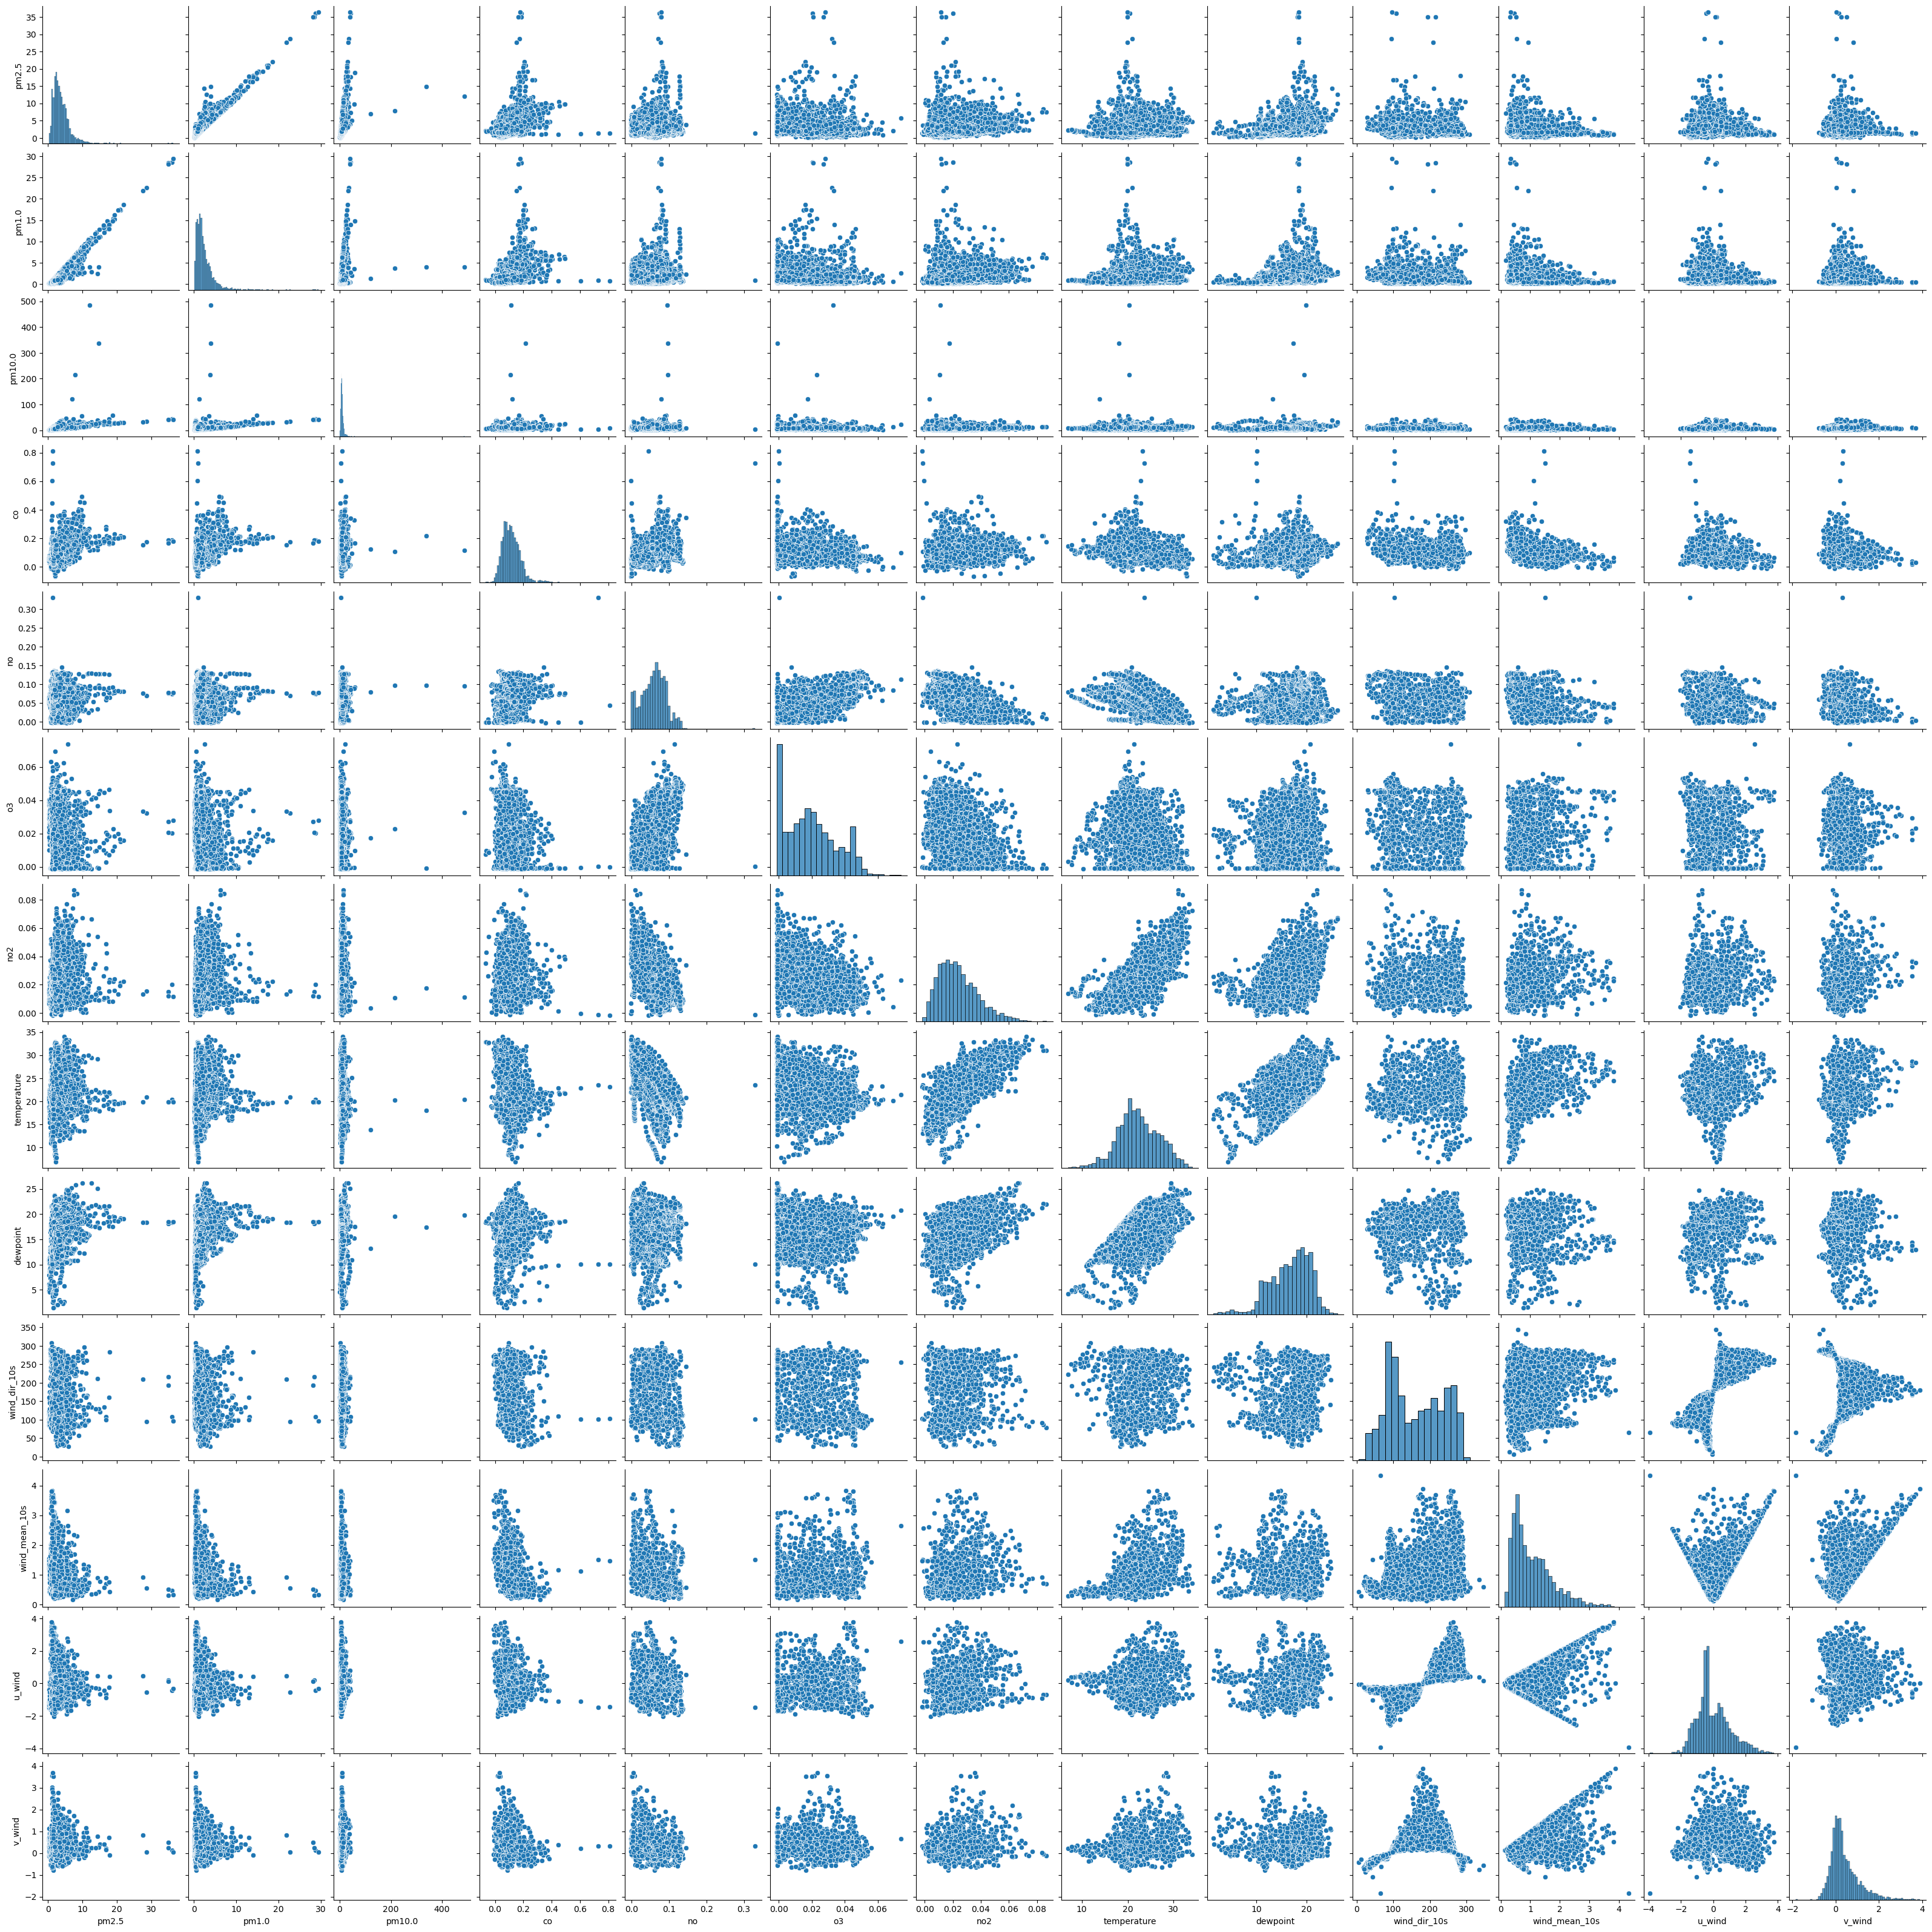

In [7]:
dp = input("Input your path for your filtered data: ").strip()

if not dp:
    print("No netCDF files found in the specified directory.")
else:
    # 1) open the file as an xarray Dataset
    ds = xr.open_dataset(dp, engine='netcdf4')
    # 2) pass the Dataset to your plotting function
    plot_variable_pairs(ds, time_frame)